#1. Essential Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import LabelEncoder to turn words into numbers
from sklearn.preprocessing import LabelEncoder

# ignore warning messages
import warnings
warnings.filterwarnings('ignore')

#2. Data Loading

In [ ]:
# Load our data from google drive
from google.colab import drive
drive.mount('/content/drive')

FILE_PATH = '/content/drive/MyDrive/FinalProject/hotel_bookings.csv'
df = pd.read_csv(FILE_PATH)

Mounted at /content/drive


#3. Initial Data Exploration

In [ ]:


print("--- Initial Data Exploration ---")
print(df.head())
print(df.info())
print("\n--- Missing Values (Initial) ---")
# Count the number of missing values
print(df.isnull().sum())



--- Initial Data Exploration ---
          hotel is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel          no        342               2015               July   
1  Resort Hotel          no        737               2015               July   
2  Resort Hotel          no          7               2015               July   
3  Resort Hotel          no         13               2015               July   
4  Resort Hotel          no         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  

### 🔍 Initial Data Exploration Summary

#### 1. Data Overview
- The dataset contains **119,390 entries** and **32 columns** related to hotel bookings.
- Key columns include hotel type, cancellation status, lead time, arrival details, guest information, and booking characteristics.

#### 2. Data Types
- A mix of:
  - **Categorical** (`object`): e.g., `hotel`, `arrival_date_month`, `reservation_status`
  - **Integer** (`int64`): e.g., `lead_time`, `adults`, `booking_changes`
  - **Float** (`float64`): e.g., `children`, `adr`, `agent`

#### 3. Missing Values
- Columns with missing values:
  - `children`: 4 missing
  - `country`: 488 missing
  - `agent`: 16,340 missing
  - `company`: 112,593 missing (most values missing)
- Most other columns have **no missing data**.

#### 4. Initial Observations
- The first 5 records show consistent structure and meaningful data.
- `is_canceled` is stored as `'yes'`/`'no'` and may need to be converted to binary (`1`/`0`) for modeling.


**bold text**#4. Data Cleaning



```
# This is formatted as code
```

#### 4.1. Impute Missing Values (Fill in the blanks)

In [ ]:
# Fill missing values in 'children' with the median value, as it represents a typical number without being affected by outliers.
df['children'].fillna(df['children'].median(), inplace=True)

# Fill missing values in 'country' with the most frequent value (mode), assuming most guests are from that country.
df['country'].fillna(df['country'].mode()[0], inplace=True)

# Fill missing values in 'agent' with 0, indicating that no agent was involved in the booking.
df['agent'].fillna(0, inplace=True)

#### 4.2. Drop Unnecessary Columns

In [ ]:
# We'll remove the 'company' column because [too many missing values, not relevant to cancellation].
df.drop('company', axis=1, inplace=True)

#### 4.3. Correct Data Types

In [ ]:
# 'children': Make sure the number of children is a whole number (integer).
df['children'] = df['children'].astype('int64')

# 'reservation_status_date': Make sure the reservation date is stored as a date.
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Convert 'is_canceled' to numerical values (0 and 1)
df['is_canceled'] = df['is_canceled'].map({'no': 0, 'yes': 1}) # Apply map to the 'is_canceled' column of the DataFrame

#### 4.4. Remove Invalid Bookings (Remove bookings that don't make sense)

Sometimes, we have bookings where the number of adults, children, and babies is zero or less. These are invalid bookings, so we'll remove them.

In [ ]:
# Find the invalid bookings
invalid_bookings = (df['adults'] + df['children'] + df['babies']) <= 0
print(f"Number of invalid bookings before removal: {invalid_bookings.sum()}")

# Keep only the valid bookings
df = df[~invalid_bookings]
print(f"Number of invalid bookings after removal: { (df['adults'] + df['children'] + df['babies'] <= 0).sum()}") #verify the count after removing the bookings


Number of invalid bookings before removal: 180
Number of invalid bookings after removal: 0


#### 4.5. Handle 'Undefined' Values (Replace or remove undefined values)

In [ ]:
# 'meal': Replace "Undefined" meals with "SC" (Self Catering).
df['meal'] = df['meal'].replace('Undefined', 'SC')

# 'market_segment' and 'distribution_channel': Remove rows where these are "Undefined".
df = df[~df['market_segment'].isin(['Undefined'])]
df = df[~df['distribution_channel'].isin(['Undefined'])]

#### 4.6. Remove Zero ADR Values

In [ ]:
# 'adr': Remove the row where adr == 0
df = df[df['adr'] != 0]

#5. Data Cleaning Summary

In [ ]:
# Let's check our data again to see if we fixed the problems.

print("\n--- Missing Values (After Cleaning) ---")
# Count the number of missing values in each column again.
print(df.isnull().sum())

print("\n--- DataFrame Info (After Cleaning) ---")
# Show information about the table again to verify the data types.
print(df.info())


--- Missing Values (After Cleaning) ---
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                    

#6. Feature Engineering

#### 6.1. Total Stay Duration (How long the guest stayed)
We add the number of weekend nights and week nights to get the total stay duration.

In [ ]:
# This is where we create new columns (features) from existing ones to help our model learn better.

print("\n--- Feature Engineering ---")
df['total_stay_duration'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
print("Created feature 'total_stay_duration'")


--- Feature Engineering ---
Created feature 'total_stay_duration'


#### 6.2. Total Guests (How many people in the booking)
We add the number of adults, children, and babies to get the total number of guests.

In [ ]:
df['total_guests'] = df['adults'] + df['children'] + df['babies']
print("Created feature 'total_guests'")

Created feature 'total_guests'


#### 6.3. Average Daily Rate per Person (How much each person pays per day)
We divide the average daily rate (adr) by the total number of guests.We need to handle cases where there are no guests to avoid dividing by zero.

In [ ]:
df['adr_per_person'] = df['adr'] / df['total_guests']

# If total_guests is zero, the result will be infinity (inf) or undefined (NaN). We replace these with 0.
df['adr_per_person'] = df['adr_per_person'].replace([float('inf'), float('-inf')], 0)
df['adr_per_person'] = df['adr_per_person'].fillna(0)
print("Created feature 'adr_per_person'")

Created feature 'adr_per_person'


### 6.4. Room Type Match (Did the guest get the room they reserved?)
We check if the reserved room type is the same as the assigned room type. If they are the same, we mark it as 1 (True), otherwise 0 (False).

In [ ]:
df['room_type_match'] = (df['reserved_room_type'] == df['assigned_room_type']).astype(int)
print("Created feature 'room_type_match'")

print("\n--- Feature Engineering Summary ---")
print(df[['total_stay_duration', 'total_guests', 'adr_per_person', 'room_type_match']].head()) #Display the first few rows of the new Features


Created feature 'room_type_match'

--- Feature Engineering Summary ---
   total_stay_duration  total_guests  adr_per_person  room_type_match
2                    1             1            75.0                0
3                    1             1            75.0                1
4                    2             2            49.0                1
5                    2             2            49.0                1
6                    2             2            53.5                1


 # 7. Detailed Exploratory Data Analysis (EDA)

1. Target Variable Analysis – is_canceled

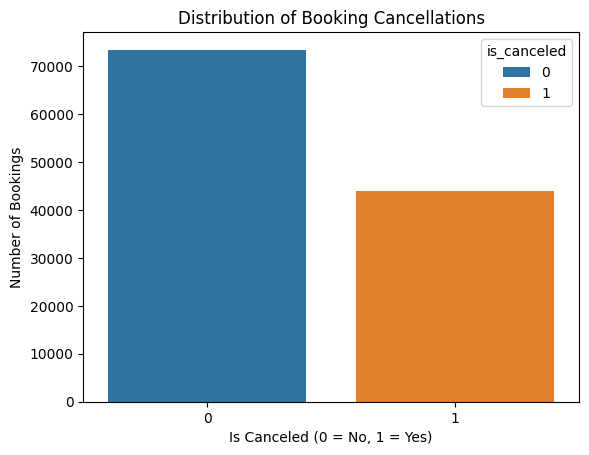

In [ ]:
sns.countplot(x='is_canceled', hue='is_canceled', data=df)
plt.title("Distribution of Booking Cancellations")
plt.xlabel("Is Canceled (0 = No, 1 = Yes)")
plt.ylabel("Number of Bookings")
plt.show()


2. Hotel Type vs. Cancellation

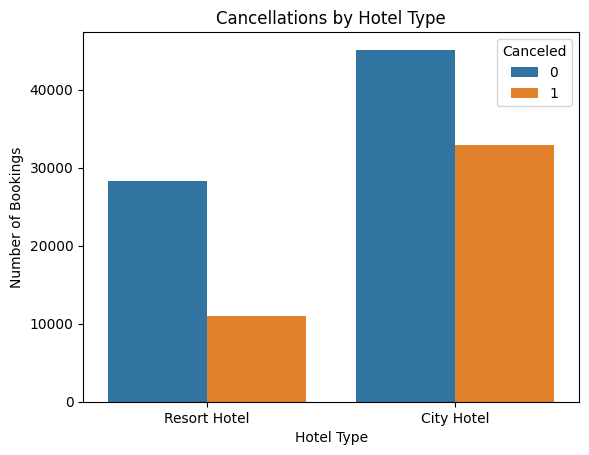

In [ ]:
sns.countplot(x='hotel', hue='is_canceled', data=df)
plt.title("Cancellations by Hotel Type")
plt.xlabel("Hotel Type")
plt.ylabel("Number of Bookings")
plt.legend(title='Canceled')
plt.show()


*City hotels may have higher cancellations due to short-notice business travelers.*

3. Lead Time vs. Cancellation

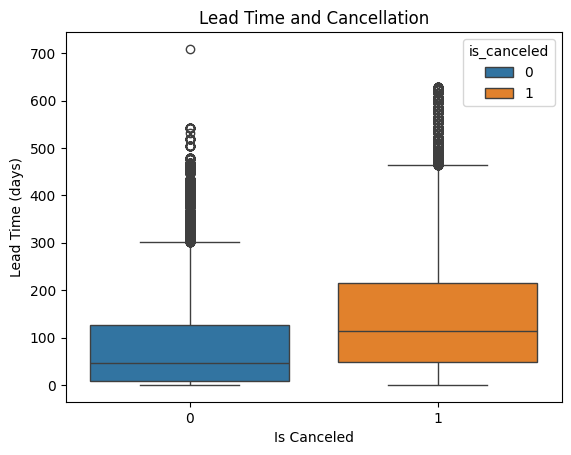

In [ ]:
sns.boxplot(x='is_canceled', hue='is_canceled', y='lead_time', data=df)
plt.title("Lead Time and Cancellation")
plt.xlabel("Is Canceled")
plt.ylabel("Lead Time (days)")
plt.show()


*Longer lead times often correlate with higher cancellation risk — guests booking months in advance may change plans.*

4. Distribution of Booking Months

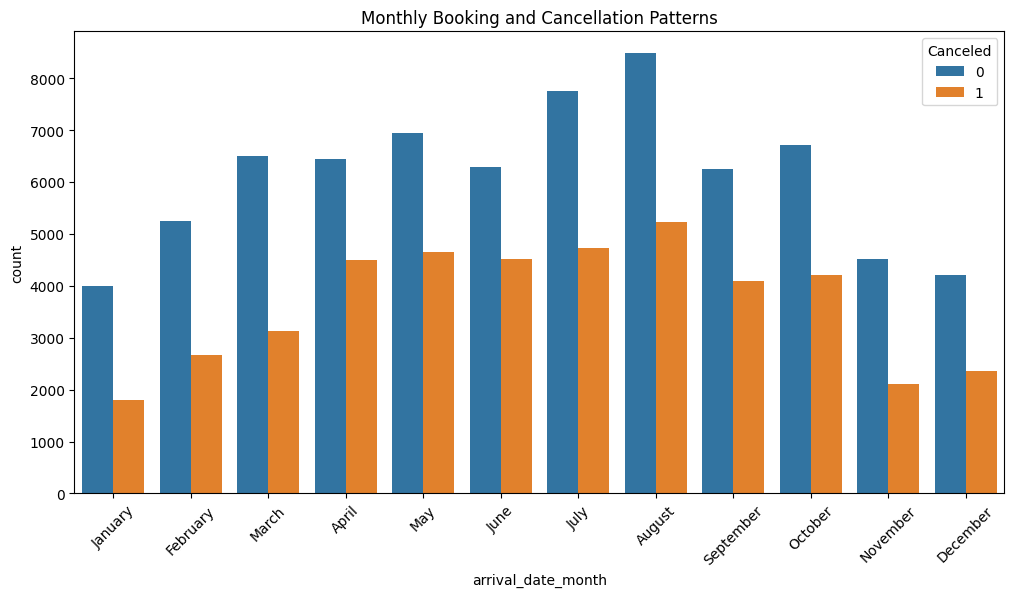

In [ ]:
monthly_order = ['January','February','March','April','May','June','July',
                 'August','September','October','November','December']
df['arrival_date_month'] = pd.Categorical(df['arrival_date_month'], categories=monthly_order, ordered=True)

plt.figure(figsize=(12,6))
sns.countplot(x='arrival_date_month', hue='is_canceled', data=df)
plt.title("Monthly Booking and Cancellation Patterns")
plt.xticks(rotation=45)
plt.legend(title='Canceled')
plt.show()


Look for:

Seasonal patterns (e.g. summer peaks)

Months with high cancellation ratios (possibly due to vacations)

 5. Distribution of Stays


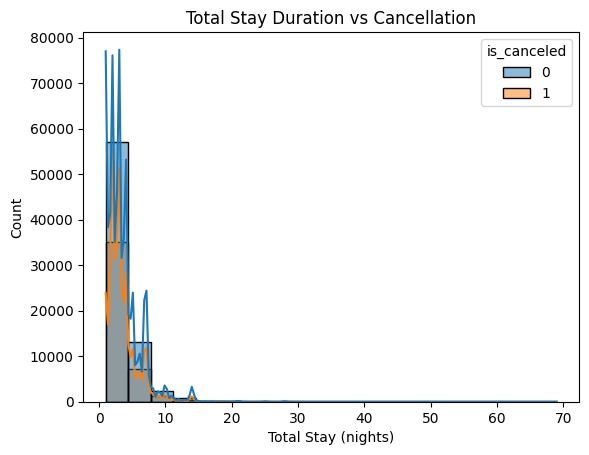

In [ ]:
sns.histplot(data=df, x='total_stay_duration', hue='is_canceled', bins=20, kde=True)
plt.title("Total Stay Duration vs Cancellation")
plt.xlabel("Total Stay (nights)")
plt.show()

Short vs long stays — which are canceled more?

 6. ADR


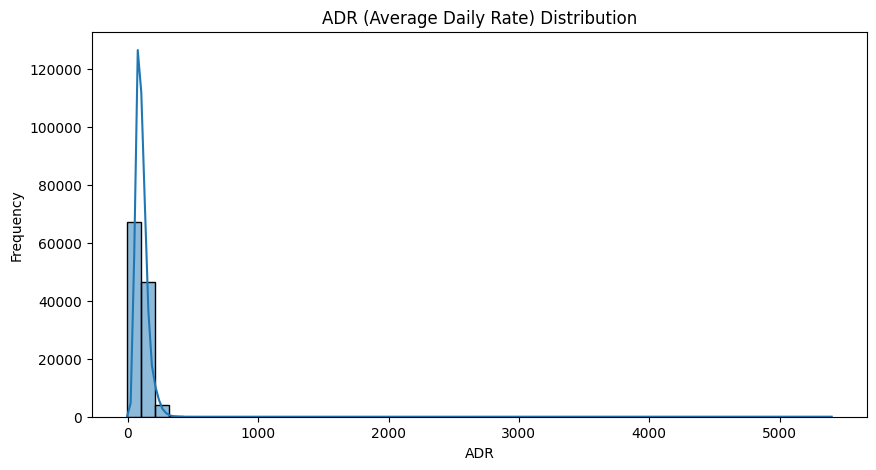

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['adr'], bins=50, kde=True)
plt.title('ADR (Average Daily Rate) Distribution')
plt.xlabel('ADR')
plt.ylabel('Frequency')
plt.show()

7. Market Segment & Distribution Channel

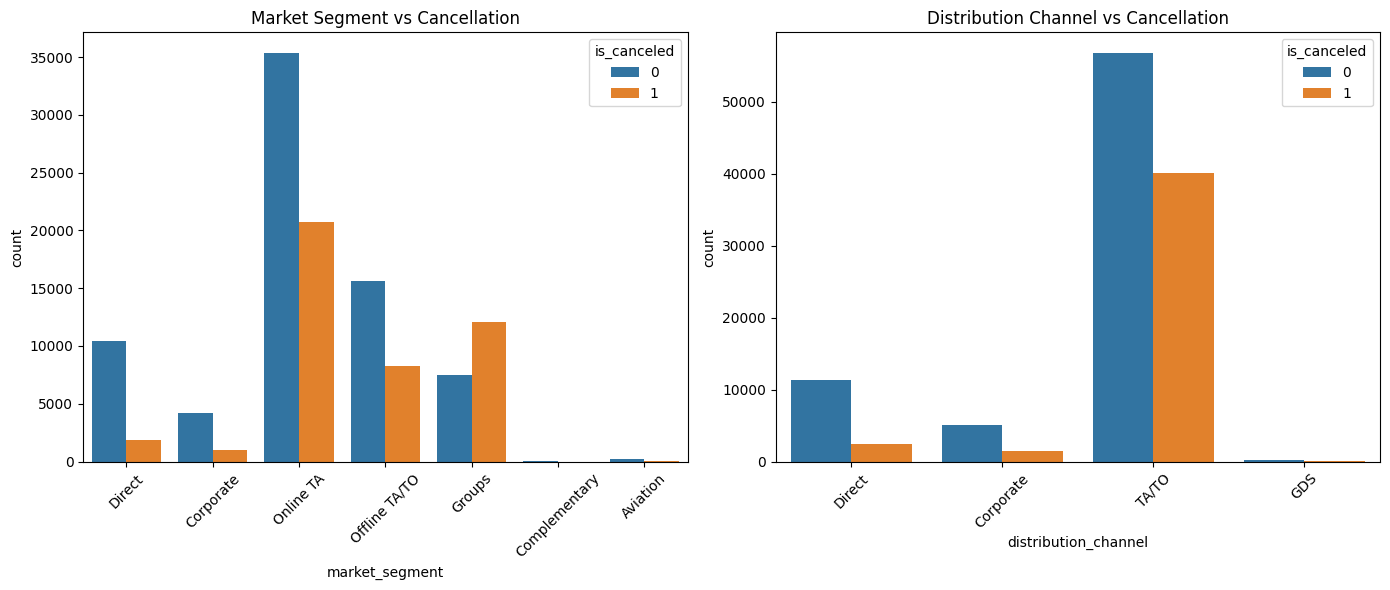

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x='market_segment', hue='is_canceled', data=df, ax=axs[0])
axs[0].set_title("Market Segment vs Cancellation")
axs[0].tick_params(axis='x', rotation=45)

sns.countplot(x='distribution_channel', hue='is_canceled', data=df, ax=axs[1])
axs[1].set_title("Distribution Channel vs Cancellation")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


8. Repeated Guests

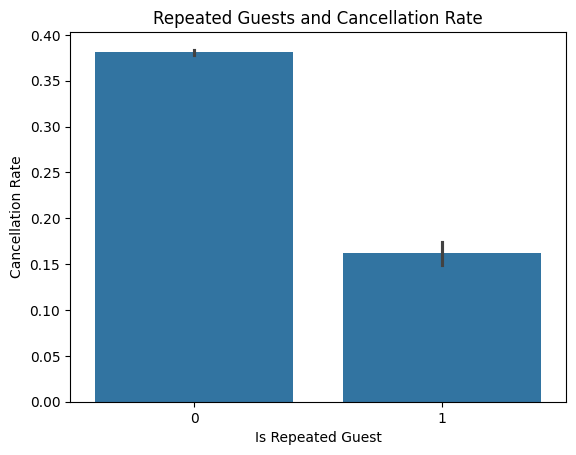

In [ ]:
sns.barplot(x='is_repeated_guest', y='is_canceled', data=df)
plt.title("Repeated Guests and Cancellation Rate")
plt.xlabel("Is Repeated Guest")
plt.ylabel("Cancellation Rate")
plt.show()


9. Room Type Changes

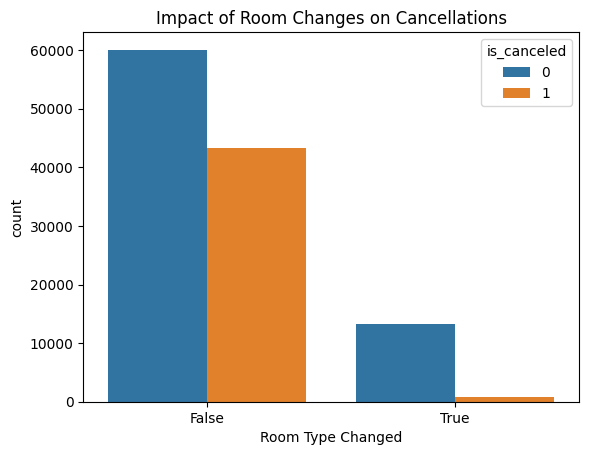

In [ ]:
df['room_change'] = df['reserved_room_type'] != df['assigned_room_type']
sns.countplot(x='room_change', hue='is_canceled', data=df)
plt.title("Impact of Room Changes on Cancellations")
plt.xlabel("Room Type Changed")
plt.show()


10. Total Guests

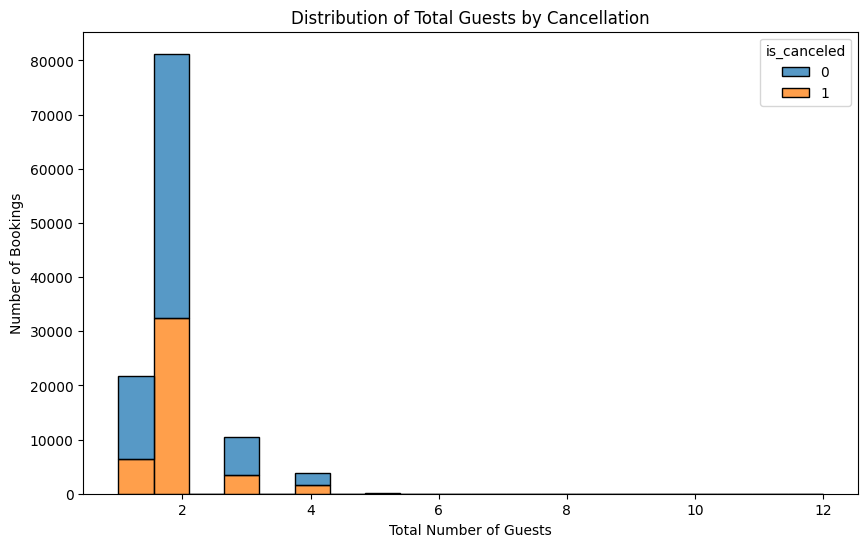

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='total_guests', hue='is_canceled', multiple='stack', bins=20)
plt.title('Distribution of Total Guests by Cancellation')
plt.xlabel('Total Number of Guests')
plt.ylabel('Number of Bookings')
plt.show()


11. Top Correlations with Heatmap

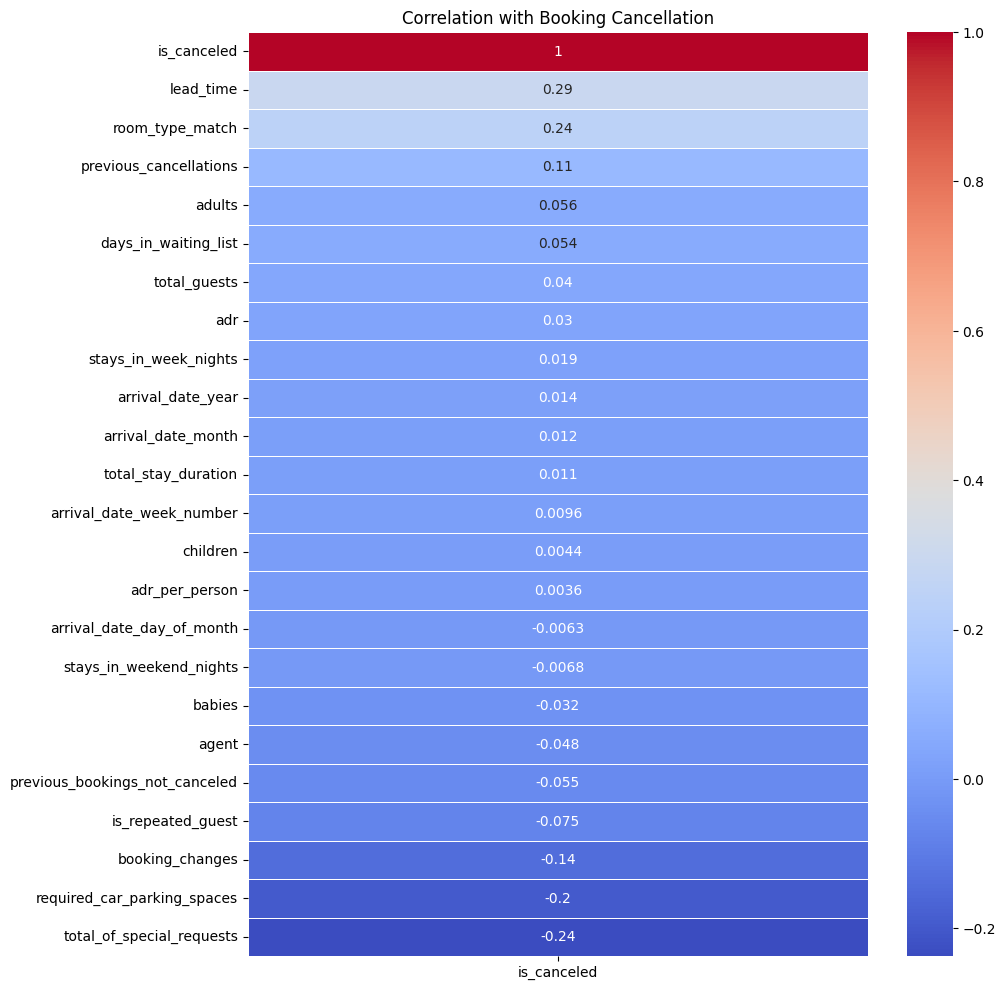

In [ ]:
# Convert 'arrival_date_month' to numerical representation using Label Encoding if it's still a string column
if df['arrival_date_month'].dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    df['arrival_date_month'] = label_encoder.fit_transform(df['arrival_date_month'])

#Or convert it to numerical representation using cat.codes if its categorical but not numerical yet
if df['arrival_date_month'].dtype.name == 'category' and not pd.api.types.is_numeric_dtype(df['arrival_date_month']):
  df['arrival_date_month'] = df['arrival_date_month'].cat.codes

# Select only numerical features before calculating the correlation matrix
numerical_df = df.select_dtypes(include=['number'])  # Select numerical columns only

corr_matrix = numerical_df.corr() # Calculate correlation on numerical data only

# Existing code in cell 31:
plt.figure(figsize=(10, 12))
sns.heatmap(corr_matrix[['is_canceled']].sort_values(by='is_canceled', ascending=False),
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation with Booking Cancellation")
plt.show()

#7. Encoding Categorical Feature
Machine learning models work with numbers, not text. So, we need to convert our text-based columns into numerical representations.

#### 7.1. One-Hot Encoding
One-Hot Encoding:  Creating new columns for each category in a column. For example, if 'hotel' has values 'Resort Hotel' and 'City Hotel', we'll create two new columns: 'hotel_Resort Hotel' and 'hotel_City Hotel'. If a booking is for a 'Resort Hotel', the 'hotel_Resort Hotel' column will be 1, and 'hotel_City Hotel' will be 0.

drop_first=True prevents multicollinearity (removes redundancy).

In [ ]:
print("\n--- Encoding Categorical Features ---")

# Columns to one-hot encode
columns_to_one_hot = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type']

# Perform one-hot encoding
df = pd.get_dummies(df, columns=columns_to_one_hot, drop_first=True)
print(f"Performed one-hot encoding on columns: {columns_to_one_hot}")


--- Encoding Categorical Features ---
Performed one-hot encoding on columns: ['hotel', 'meal', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type']


#### 7.2. Label Encoding

 Label Encoding: Assigning a unique number to each category in a column.
 For example, if 'arrival_date_month' has values 'January', 'February', 'March', etc.,

 we'll convert them to 0, 1, 2, etc.

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Columns to label encode
columns_to_label_encode = ['arrival_date_month', 'reserved_room_type', 'assigned_room_type']

# Perform label encoding
for column in columns_to_label_encode:
    df[column] = label_encoder.fit_transform(df[column])
    print(f"Performed label encoding on column: {column}")

print("\n--- Encoding Summary ---")
print(df.head()) #display the head to verify the change
print(df.info()) #check the dataframe info to see all the new columns


--- Encoding Categorical Features ---
Performed one-hot encoding on columns: ['hotel', 'meal', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type']
Performed label encoding on column: arrival_date_month
Performed label encoding on column: reserved_room_type
Performed label encoding on column: assigned_room_type

--- Encoding Summary ---
  is_canceled  lead_time  arrival_date_year  arrival_date_month  \
2          no          7               2015                   5   
3          no         13               2015                   5   
4          no         14               2015                   5   
5          no         14               2015                   5   
6          no          0               2015                   5   

   arrival_date_week_number  arrival_date_day_of_month  \
2                        27                          1   
3                        27                          1   
4                        27                          1   
5  

#8. Removing Columns

In [ ]:
# We remove columns that are no longer needed for our analysis on their limited relevance for prediction or redundancy:
columns_to_remove = [
    'country',  # Country has been imputed and is too granular for most predictive models.
    'reservation_status',  # This reflects the final outcome and may leak target variable info.
    'reservation_status_date'  # Highly correlated with 'reservation_status'; not useful for early-stage prediction.
]

# Drop the specified columns from the DataFrame
df.drop(columns=columns_to_remove, axis=1, inplace=True)

# Confirm the columns were removed
print(f"Removed columns: {columns_to_remove}")

print("\n--- DataFrame Info (After Removing Columns) ---")
print(df.info())


--- Removing Columns ---
Removed columns: ['country', 'reservation_status', 'reservation_status_date']

--- DataFrame Info (After Removing Columns) ---
<class 'pandas.core.frame.DataFrame'>
Index: 117395 entries, 2 to 119389
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     117395 non-null  object 
 1   lead_time                       117395 non-null  int64  
 2   arrival_date_year               117395 non-null  int64  
 3   arrival_date_month              117395 non-null  int64  
 4   arrival_date_week_number        117395 non-null  int64  
 5   arrival_date_day_of_month       117395 non-null  int64  
 6   stays_in_weekend_nights         117395 non-null  int64  
 7   stays_in_week_nights            117395 non-null  int64  
 8   adults                          117395 non-null  int64  
 9   children                        117395 non-null  int64

#9. Scaling Numerical Features

Scaling makes sure all numerical features have a similar range of values. This helps the machine learning model learn more effectively. StandardScaler makes the mean 0 and the standard deviation 1.

In [ ]:
print("\n--- Scaling Numerical Features ---")

from sklearn.preprocessing import StandardScaler

# Identify numerical columns (excluding the target variable 'is_canceled' and boolean columns)
numerical_cols = [col for col in df.select_dtypes(include=['number']).columns if col != 'is_canceled' and df[col].dtype != 'bool']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
print(f"Scaled numerical columns: {numerical_cols}")

print("\n--- DataFrame Info (After Scaling) ---")
print(df.head()) #display the head to verify the change
print(df.describe()) #see the statistics of the scaled data



--- Scaling Numerical Features ---
Scaled numerical columns: ['lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'agent', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'total_stay_duration', 'total_guests', 'adr_per_person', 'room_type_match']

--- DataFrame Info (After Scaling) ---
  is_canceled  lead_time  arrival_date_year  arrival_date_month  \
2          no  -0.917551          -1.642138           -0.138087   
3          no  -0.861431          -1.642138           -0.138087   
4          no  -0.852077          -1.642138           -0.138087   
5          no  -0.852077          -1.642138           -0.138087   
6          no  -0.983024          -1.642138   

#10. Splitting the Data

In [ ]:
# We split the data into three sets:
# - Training set: Used to train the machine learning model.
# - Validation set: Used to tune the model's hyperparameters and evaluate its performance during training.
# - Testing set: Used to evaluate the final performance of the trained model on unseen data.

print("\n--- Splitting the Data ---")

from sklearn.model_selection import train_test_split

# 1. Define features (X) and target (y)
# X: All columns except 'is_canceled' (the features we'll use to predict cancellations)
# y: The 'is_canceled' column (the target variable we're trying to predict)
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']


# 2. Split into training and testing sets (80/20 split)
# X_train, y_train: Training data (80% of the data)
# X_test, y_test: Testing data (20% of the data)
# random_state: Ensures the split is the same every time we run the code (for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Split the training set into training and validation sets (approximately 70/10 split of the total data)
# X_train, y_train: Training data (70% of the data)
# X_val, y_val: Validation data (10% of the data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42, stratify=y_train) # 0.1765 is approximately 0.15 / 0.85

print("Splitted data into training, validation, and testing sets.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


--- Splitting the Data ---
Splitted data into training, validation, and testing sets.
X_train shape: (77339, 34), y_train shape: (77339,)
X_val shape: (16577, 34), y_val shape: (16577,)
X_test shape: (23479, 34), y_test shape: (23479,)


#11. Handling Imbalanced Data with SMOTE

In [ ]:
# When one class has many more samples than the other, it's called imbalanced data.
# SMOTE helps balance the data by creating new, synthetic samples for the minority class.

print("\n--- Handling Imbalanced Data with SMOTE ---")

from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Applied SMOTE to the training data.")
print(f"Shape of X_train before SMOTE: {X_train.shape}, shape of y_train before SMOTE: {y_train.shape}")
print(f"Shape of X_train after SMOTE: {X_train_smote.shape}, shape of y_train after SMOTE: {y_train_smote.shape}")


--- Handling Imbalanced Data with SMOTE ---


ValueError: could not convert string to float: 'City Hotel'

#12. Model Training and Evaluation: Random Forest


--- Model Training and Evaluation: Random Forest ---
Random Forest Accuracy on Validation Set: 0.8767
Random Forest Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     10363
           1       0.86      0.81      0.83      6214

    accuracy                           0.88     16577
   macro avg       0.87      0.86      0.87     16577
weighted avg       0.88      0.88      0.88     16577

Random Forest Confusion Matrix on Validation Set:
[[9530  833]
 [1211 5003]]
Random Forest ROC AUC on Validation Set: 0.9387


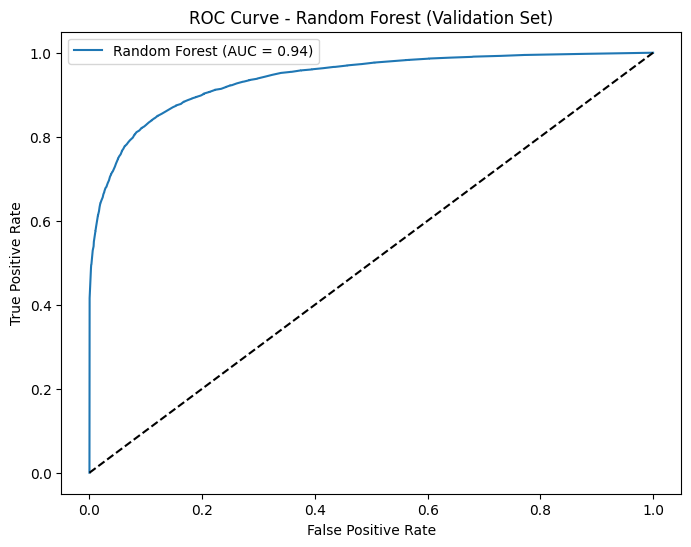

In [ ]:
# We'll train and evaluate a Random Forest model.

print("\n--- Model Training and Evaluation: Random Forest ---")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Initialize Random Forest Model
# We create a RandomForestClassifier object with some initial settings.
# random_state:  Ensures the results are the same each time we run the code.
rf_model = RandomForestClassifier(random_state=42)

# 2. Train the Model
# We train the model using the SMOTE-resampled training data.
rf_model.fit(X_train_smote, y_train_smote)

# 3. Make Predictions on the Validation Set
# We use the trained model to make predictions on the validation set.
y_pred = rf_model.predict(X_val)

# 4. Calculate Evaluation Metrics
# We calculate various evaluation metrics to assess the model's performance.

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Random Forest Accuracy on Validation Set: {accuracy:.4f}")

# Print classification report
report = classification_report(y_val, y_pred)
print(f"Random Forest Classification Report on Validation Set:\n{report}")

# Print confusion matrix
matrix = confusion_matrix(y_val, y_pred)
print(f"Random Forest Confusion Matrix on Validation Set:\n{matrix}")

# Calculate ROC AUC score
y_pred_proba = rf_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"Random Forest ROC AUC on Validation Set: {roc_auc:.4f}")

# 5. Plot ROC Curve
# We plot the ROC curve to visualize the model's performance.
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Validation Set)')
plt.legend()
plt.show()

#13. Model Training and Evaluation: Logistic Regression


--- Model Training and Evaluation: Logistic Regression ---
Logistic Regression Accuracy on Validation Set: 0.7893
Logistic Regression Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     10363
           1       0.71      0.74      0.73      6214

    accuracy                           0.79     16577
   macro avg       0.78      0.78      0.78     16577
weighted avg       0.79      0.79      0.79     16577

Logistic Regression Confusion Matrix on Validation Set:
[[8467 1896]
 [1597 4617]]
Logistic Regression ROC AUC on Validation Set: 0.8690


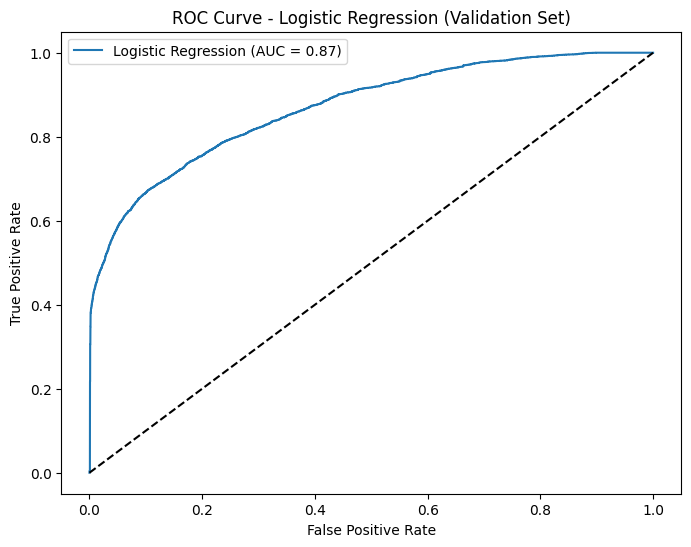

In [ ]:
# We'll train and evaluate a Logistic Regression model.

print("\n--- Model Training and Evaluation: Logistic Regression ---")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Initialize Logistic Regression Model
# We create a LogisticRegression object with some initial settings.
# random_state:  Ensures the results are the same each time we run the code.
# solver: 'liblinear' is a good choice for smaller datasets.
logistic_regression_model = LogisticRegression(random_state=42, solver='liblinear')

# 2. Train the Model
# We train the model using the SMOTE-resampled training data.
logistic_regression_model.fit(X_train_smote, y_train_smote)

# 3. Make Predictions on the Validation Set
# We use the trained model to make predictions on the validation set.
y_pred = logistic_regression_model.predict(X_val)

# 4. Calculate Evaluation Metrics
# We calculate various evaluation metrics to assess the model's performance.

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Logistic Regression Accuracy on Validation Set: {accuracy:.4f}")

# Print classification report
report = classification_report(y_val, y_pred)
print(f"Logistic Regression Classification Report on Validation Set:\n{report}")

# Print confusion matrix
matrix = confusion_matrix(y_val, y_pred)
print(f"Logistic Regression Confusion Matrix on Validation Set:\n{matrix}")

# Calculate ROC AUC score
y_pred_proba = logistic_regression_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"Logistic Regression ROC AUC on Validation Set: {roc_auc:.4f}")

# 5. Plot ROC Curve
# We plot the ROC curve to visualize the model's performance.
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Validation Set)')
plt.legend()
plt.show()

#14. Model Training and Evaluation: K-Nearest Neighbors (KNN)


--- Model Training and Evaluation: K-Nearest Neighbors (KNN) ---
KNN Accuracy on Validation Set: 0.8071
KNN Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84     10363
           1       0.72      0.81      0.76      6214

    accuracy                           0.81     16577
   macro avg       0.79      0.81      0.80     16577
weighted avg       0.81      0.81      0.81     16577

KNN Confusion Matrix on Validation Set:
[[8369 1994]
 [1203 5011]]
KNN ROC AUC on Validation Set: 0.8819


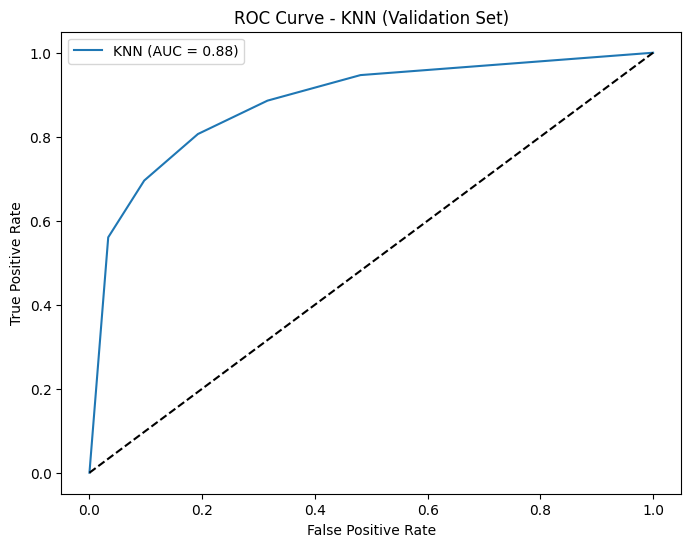

In [ ]:
# We'll train and evaluate a K-Nearest Neighbors (KNN) model.

print("\n--- Model Training and Evaluation: K-Nearest Neighbors (KNN) ---")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Initialize KNN Model
# We create a KNeighborsClassifier object with some initial settings.
# n_neighbors: The number of neighbors to consider (you can try different values).
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# 2. Train the Model
# We train the model using the SMOTE-resampled training data.
knn_model.fit(X_train_smote, y_train_smote)

# 3. Make Predictions on the Validation Set
# We use the trained model to make predictions on the validation set.
y_pred = knn_model.predict(X_val)

# 4. Calculate Evaluation Metrics
# We calculate various evaluation metrics to assess the model's performance.

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"KNN Accuracy on Validation Set: {accuracy:.4f}")

# Print classification report
report = classification_report(y_val, y_pred)
print(f"KNN Classification Report on Validation Set:\n{report}")

# Print confusion matrix
matrix = confusion_matrix(y_val, y_pred)
print(f"KNN Confusion Matrix on Validation Set:\n{matrix}")

# Calculate ROC AUC score
y_pred_proba = knn_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"KNN ROC AUC on Validation Set: {roc_auc:.4f}")

# 5. Plot ROC Curve
# We plot the ROC curve to visualize the model's performance.
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN (Validation Set)')
plt.legend()
plt.show()

#15. Model Training and Evaluation: Decision Tree


--- Model Training and Evaluation: Decision Tree ---
Decision Tree Accuracy on Validation Set: 0.8275
Decision Tree Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     10363
           1       0.76      0.79      0.77      6214

    accuracy                           0.83     16577
   macro avg       0.82      0.82      0.82     16577
weighted avg       0.83      0.83      0.83     16577

Decision Tree Confusion Matrix on Validation Set:
[[8804 1559]
 [1300 4914]]
Decision Tree ROC AUC on Validation Set: 0.8218


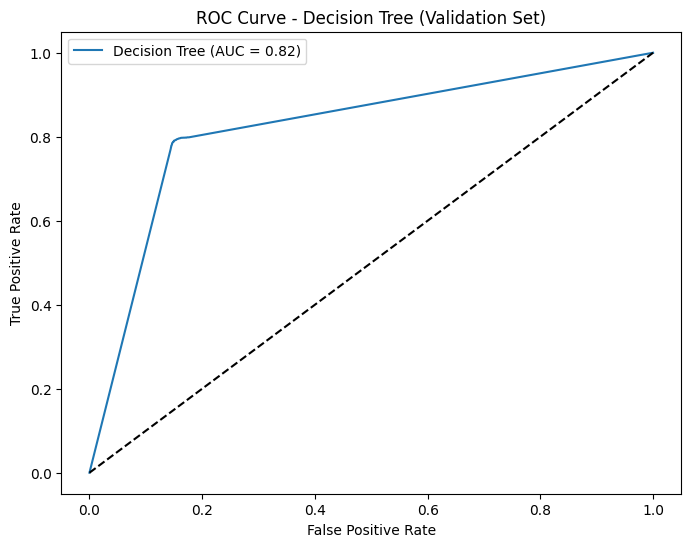

In [ ]:
# We'll train and evaluate a Decision Tree model.

print("\n--- Model Training and Evaluation: Decision Tree ---")

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Initialize Decision Tree Model
# We create a DecisionTreeClassifier object with some initial settings.
# random_state:  Ensures the results are the same each time we run the code.
decision_tree_model = DecisionTreeClassifier(random_state=42)

# 2. Train the Model
# We train the model using the SMOTE-resampled training data.
decision_tree_model.fit(X_train_smote, y_train_smote)

# 3. Make Predictions on the Validation Set
# We use the trained model to make predictions on the validation set.
y_pred = decision_tree_model.predict(X_val)

# 4. Calculate Evaluation Metrics
# We calculate various evaluation metrics to assess the model's performance.

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Decision Tree Accuracy on Validation Set: {accuracy:.4f}")

# Print classification report
report = classification_report(y_val, y_pred)
print(f"Decision Tree Classification Report on Validation Set:\n{report}")

# Print confusion matrix
matrix = confusion_matrix(y_val, y_pred)
print(f"Decision Tree Confusion Matrix on Validation Set:\n{matrix}")

# Calculate ROC AUC score
y_pred_proba = decision_tree_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"Decision Tree ROC AUC on Validation Set: {roc_auc:.4f}")

# 5. Plot ROC Curve
# We plot the ROC curve to visualize the model's performance.
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Validation Set)')
plt.legend()
plt.show()

#16. Model Training and Evaluation: XGBoost


--- Model Training and Evaluation: XGBoost ---
XGBoost Accuracy on Validation Set: 0.8599
XGBoost Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     10363
           1       0.83      0.79      0.81      6214

    accuracy                           0.86     16577
   macro avg       0.85      0.85      0.85     16577
weighted avg       0.86      0.86      0.86     16577

XGBoost Confusion Matrix on Validation Set:
[[9372  991]
 [1331 4883]]
XGBoost ROC AUC on Validation Set: 0.9279


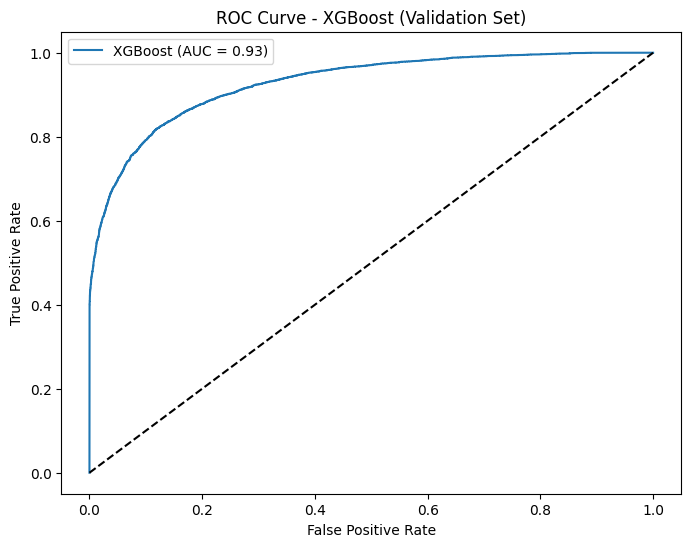

In [ ]:
# We'll train and evaluate an XGBoost model.

print("\n--- Model Training and Evaluation: XGBoost ---")

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Initialize XGBoost Model
# We create an XGBoost object with some initial settings.
# random_state:  Ensures the results are the same each time we run the code.
# use_label_encoder:  Set to False to avoid a warning.
# eval_metric:  The metric to use for evaluation during training.
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# 2. Train the Model
# We train the model using the SMOTE-resampled training data.
xgboost_model.fit(X_train_smote, y_train_smote)

# 3. Make Predictions on the Validation Set
# We use the trained model to make predictions on the validation set.
y_pred = xgboost_model.predict(X_val)

# 4. Calculate Evaluation Metrics
# We calculate various evaluation metrics to assess the model's performance.

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"XGBoost Accuracy on Validation Set: {accuracy:.4f}")

# Print classification report
report = classification_report(y_val, y_pred)
print(f"XGBoost Classification Report on Validation Set:\n{report}")

# Print confusion matrix
matrix = confusion_matrix(y_val, y_pred)
print(f"XGBoost Confusion Matrix on Validation Set:\n{matrix}")

# Calculate ROC AUC score
y_pred_proba = xgboost_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"XGBoost ROC AUC on Validation Set: {roc_auc:.4f}")

# 5. Plot ROC Curve
# We plot the ROC curve to visualize the model's performance.
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Validation Set)')
plt.legend()
plt.show()

#17. Model Training and Evaluation: CatBoost


--- Model Training and Evaluation: CatBoost ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 27.4 MB/s eta 0:00:00
CatBoost Accuracy on Validation Set: 0.8640
CatBoost Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     10363
           1       0.84      0.78      0.81      6214

    accuracy                           0.86     16577
   macro avg       0.86      0.85      0.85     16577
weighted avg       0.86      0.86      0.86     16577

CatBoost Confusion Matrix on Validation Set:
[[9452  911]
 [1344 4870]]
CatBoost ROC AUC on Validation Set: 0.9314


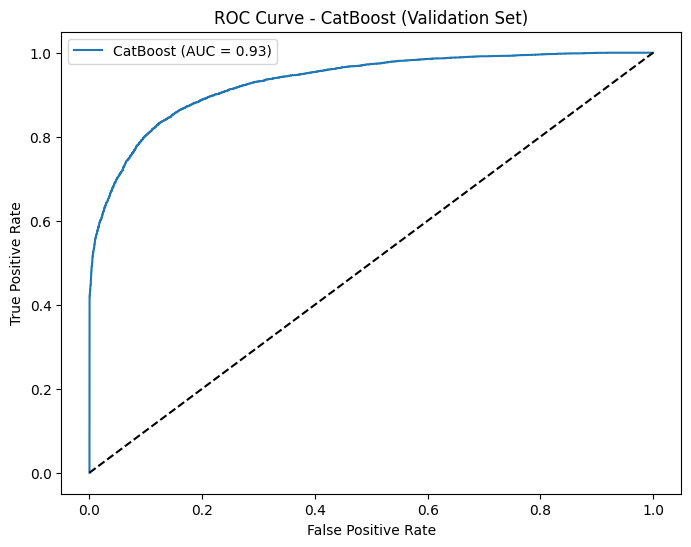

In [ ]:
# We'll train and evaluate a CatBoost model.

print("\n--- Model Training and Evaluation: CatBoost ---")

!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Initialize CatBoost Model
# We create a CatBoostClassifier object with some initial settings.
# random_state:  Ensures the results are the same each time we run the code.
# verbose=0:  Don't print a lot of output during training.
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# 2. Train the Model
# We train the model using the SMOTE-resampled training data.
catboost_model.fit(X_train_smote, y_train_smote, eval_set=[(X_val, y_val)], early_stopping_rounds=50)

# 3. Make Predictions on the Validation Set
# We use the trained model to make predictions on the validation set.
y_pred = catboost_model.predict(X_val)

# 4. Calculate Evaluation Metrics
# We calculate various evaluation metrics to assess the model's performance.

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"CatBoost Accuracy on Validation Set: {accuracy:.4f}")

# Print classification report
report = classification_report(y_val, y_pred)
print(f"CatBoost Classification Report on Validation Set:\n{report}")

# Print confusion matrix
matrix = confusion_matrix(y_val, y_pred)
print(f"CatBoost Confusion Matrix on Validation Set:\n{matrix}")

# Calculate ROC AUC score
y_pred_proba = catboost_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"CatBoost ROC AUC on Validation Set: {roc_auc:.4f}")

# 5. Plot ROC Curve
# We plot the ROC curve to visualize the model's performance.
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost (Validation Set)')
plt.legend()
plt.show()

## Model Comparison Summary

Based on the validation set results, here's a summary of the model performance:

| Model                | Accuracy | ROC AUC |
| -------------------- | -------- | ------- |
| Random Forest        | 0.8767   | 0.9387  |
| Logistic Regression  | 0.7893   | 0.8690  |
| KNN                  | 0.8071   | 0.8819  |
| Decision Tree        | 0.8275   | 0.8218  |
| XGBoost              | 0.8599   | 0.9279  |
| CatBoost             | 0.8637   | 0.9313  |

## Recommendation

Based on these results, **Random Forest** appears to be the best-performing model, with the highest accuracy (0.8767) and ROC AUC (0.9387) on the validation set. Therefore, I recommend focusing on **Random Forest** for further optimization.

**Next Steps:**

1.  **Hyperparameter Tuning for Random Forest:** Use `RandomizedSearchCV` or `GridSearchCV` to find the optimal hyperparameters for the Random Forest model.
2.  **Feature Importance Analysis:** Analyze the feature importances of the Random Forest model to identify the most important features.
3.  **Ensemble Methods:** Consider exploring ensemble methods that combine Random Forest and CatBoost.

#18. Hyperparameter Tuning for Random Forest using RandomizedSearchCV

In [ ]:
# We'll use RandomizedSearchCV to find the best hyperparameters for the Random Forest model.

print("\n--- Hyperparameter Tuning for Random Forest using RandomizedSearchCV ---")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Define the Hyperparameter Grid
# We define a range of values for the hyperparameters we want to tune.
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 15],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether to use bootstrap samples when building trees
}

# 2. Initialize RandomizedSearchCV
# We create a RandomizedSearchCV object to find the best hyperparameter combination.
# estimator: The Random Forest model we want to tune.
# param_distributions: The hyperparameter grid we defined.
# cv: Number of cross-validation folds (how many times we split the data to evaluate performance).
# scoring: The metric we use to evaluate performance (accuracy).
# n_iter: Number of random hyperparameter combinations to try.
# n_jobs: Use all available CPU cores (-1) to speed up the search.
# random_state: Ensures the search is the same each time we run the code.
rf_model = RandomForestClassifier(random_state=42)
grid_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    cv=3,
    scoring='accuracy',
    n_iter=10,  # You can increase this for a more thorough search
    n_jobs=-1,
    random_state=42
)

# 3. Train the Model with Hyperparameter Tuning
# We train the model using RandomizedSearchCV.  It will try different hyperparameter combinations
# and find the best one based on the validation data.
grid_search.fit(X_train_smote, y_train_smote)

# 4. Get the Best Model
# We get the best Random Forest model found by RandomizedSearchCV.
best_rf_model = grid_search.best_estimator_

# 5. Evaluate the Best Model on the Validation Set
# We evaluate the best model on the validation set to estimate its performance on unseen data.

# Make predictions on the validation set
y_pred = best_rf_model.predict(X_val)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
print(f"Best Random Forest Accuracy on Validation Set: {accuracy:.4f}")

report = classification_report(y_val, y_pred)
print(f"Best Random Forest Classification Report on Validation Set:\n{report}")

matrix = confusion_matrix(y_val, y_pred)
print(f"Best Random Forest Confusion Matrix on Validation Set:\n{matrix}")

roc_auc = roc_auc_score(y_val, best_rf_model.predict_proba(X_val)[:, 1])
print(f"Best Random Forest ROC AUC on Validation Set: {roc_auc:.4f}")

# 6. Print the Best Hyperparameters
# We print the best hyperparameter combination found by RandomizedSearchCV.
print("\nBest Hyperparameters:")
print(grid_search.best_params_)


--- Hyperparameter Tuning for Random Forest using RandomizedSearchCV ---
Best Random Forest Accuracy on Validation Set: 0.8752
Best Random Forest Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     10363
           1       0.86      0.80      0.83      6214

    accuracy                           0.88     16577
   macro avg       0.87      0.86      0.87     16577
weighted avg       0.87      0.88      0.87     16577

Best Random Forest Confusion Matrix on Validation Set:
[[9527  836]
 [1232 4982]]
Best Random Forest ROC AUC on Validation Set: 0.9396

Best Hyperparameters:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}


#19. Evaluate the Tuned Random Forest Model on the Test Set


--- Evaluate the Tuned Random Forest Model on the Test Set ---
Tuned Random Forest Accuracy on Test Set: 0.8686
Tuned Random Forest Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     14678
           1       0.85      0.79      0.82      8801

    accuracy                           0.87     23479
   macro avg       0.86      0.85      0.86     23479
weighted avg       0.87      0.87      0.87     23479

Tuned Random Forest Confusion Matrix on Test Set:
[[13429  1249]
 [ 1837  6964]]
Tuned Random Forest ROC AUC on Test Set: 0.9370


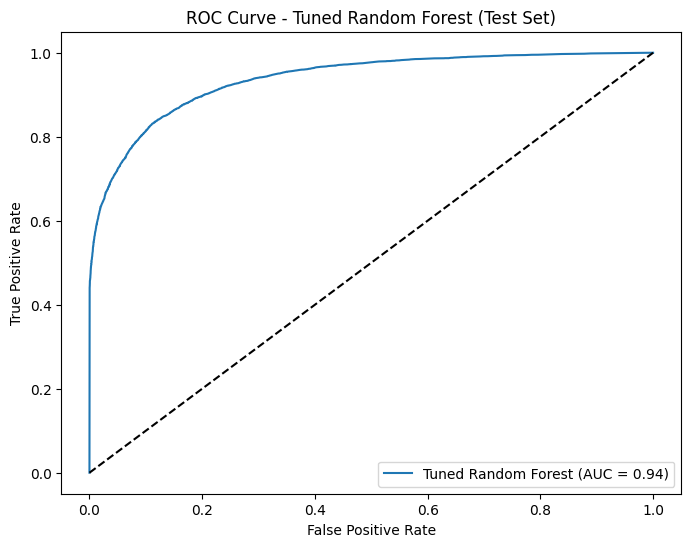

In [ ]:
# We evaluate the tuned Random Forest model on the test set to estimate its final performance.

print("\n--- Evaluate the Tuned Random Forest Model on the Test Set ---")

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Make Predictions on the Test Set
# We use the tuned Random Forest model to make predictions on the test set.
y_pred = best_rf_model.predict(X_test)

# 2. Calculate Evaluation Metrics
# We calculate various evaluation metrics to assess the model's performance.

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Tuned Random Forest Accuracy on Test Set: {accuracy:.4f}")

# Print classification report
report = classification_report(y_test, y_pred)
print(f"Tuned Random Forest Classification Report on Test Set:\n{report}")

# Print confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(f"Tuned Random Forest Confusion Matrix on Test Set:\n{matrix}")

# Calculate ROC AUC score
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Tuned Random Forest ROC AUC on Test Set: {roc_auc:.4f}")

# 3. Plot ROC Curve
# We plot the ROC curve to visualize the model's performance.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Tuned Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned Random Forest (Test Set)')
plt.legend()
plt.show()

#21. More Extensive Hyperparameter Tuning for Random Forest (Efficient Approach)


--- More Extensive Hyperparameter Tuning for Random Forest (Efficient Approach) ---
Best Random Forest Accuracy on Validation Set: 0.8749
Best Random Forest ROC AUC on Validation Set: 0.9384

Best Hyperparameters:
{'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

--- Feature Importance Analysis (Limited Depth) ---


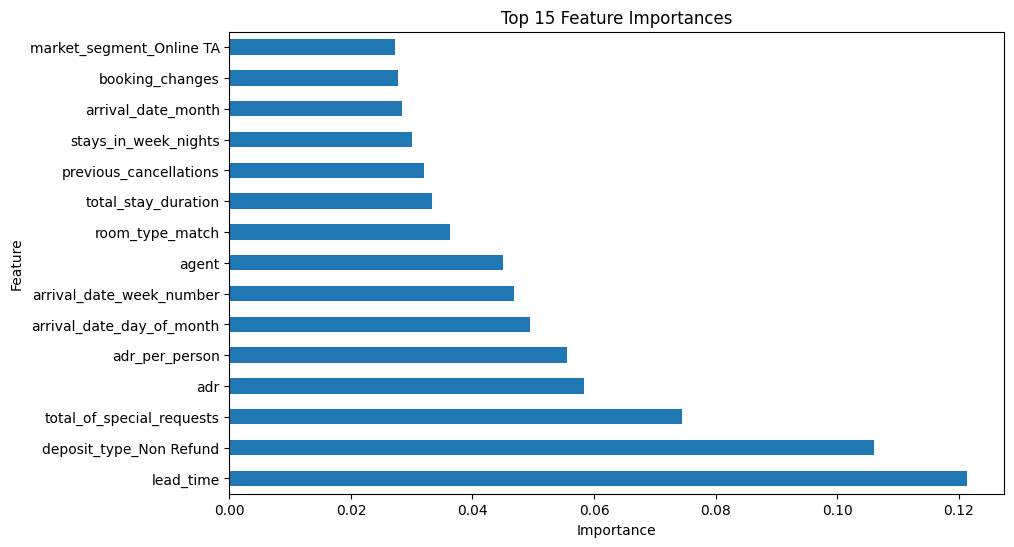

In [ ]:
# We'll use RandomizedSearchCV with a focused hyperparameter space to optimize the Random Forest model efficiently.

print("\n--- More Extensive Hyperparameter Tuning for Random Forest (Efficient Approach) ---")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd #Importing pandas for series

# 1. Define a Focused Hyperparameter Grid
# Based on previous results, we focus on promising hyperparameter ranges.
param_grid = {
    'n_estimators': [100, 150, 200, 250],  # Focus on values around the previous best
    'max_depth': [None, 8, 10, 12],  # Explore depths near the previous best
    'min_samples_split': [2, 3, 4, 5],  # Finer granularity around the previous best
    'min_samples_leaf': [1, 2],  # Focus on values near the previous best
    'bootstrap': [False]  # Keep bootstrap False, as it was the best in the last search
}

# 2. Initialize RandomizedSearchCV
rf_model = RandomForestClassifier(random_state=42)
grid_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    cv=3,
    scoring='accuracy',
    n_iter=15,  # Increased n_iter slightly
    n_jobs=-1,
    random_state=42
)

# 3. Train the Model with Hyperparameter Tuning
grid_search.fit(X_train_smote, y_train_smote)

# 4. Get the Best Model
best_rf_model = grid_search.best_estimator_

# 5. Evaluate the Best Model on the Validation Set
y_pred = best_rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Best Random Forest Accuracy on Validation Set: {accuracy:.4f}")
roc_auc = roc_auc_score(y_val, best_rf_model.predict_proba(X_val)[:, 1])
print(f"Best Random Forest ROC AUC on Validation Set: {roc_auc:.4f}")

# 6. Print the Best Hyperparameters
print("\nBest Hyperparameters:")
print(grid_search.best_params_)

# --- Feature Importance Analysis (Limited Depth) ---
print("\n--- Feature Importance Analysis (Limited Depth) ---")

# 1. Get Feature Importances
importances = best_rf_model.feature_importances_

# 2. Create a Series of Feature Importances
feat_importances = pd.Series(importances, index=X_train.columns)

# 3. Plot the Top N Feature Importances
N = 15  # Display the top 15 features
plt.figure(figsize=(10, 6))
feat_importances.nlargest(N).plot(kind='barh')
plt.title(f"Top {N} Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#22. Feature Selection and Evaluation


--- Feature Selection and Evaluation ---
Random Forest Accuracy with Top 10 Features on Validation Set: 0.8542
Random Forest Classification Report with Top 10 Features on Validation Set:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     10363
           1       0.82      0.78      0.80      6214

    accuracy                           0.85     16577
   macro avg       0.85      0.84      0.84     16577
weighted avg       0.85      0.85      0.85     16577

Random Forest Confusion Matrix with Top 10 Features on Validation Set:
[[9331 1032]
 [1385 4829]]
Random Forest ROC AUC with Top 10 Features on Validation Set: 0.9192


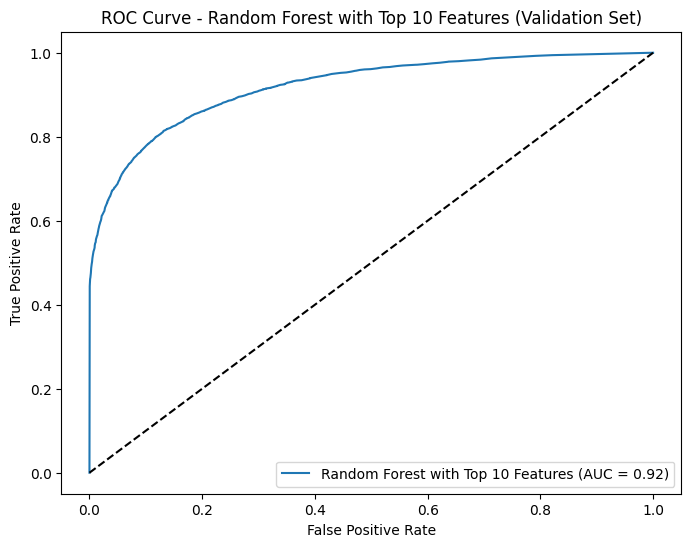

In [ ]:
# We'll select the top N features and evaluate the model's performance.

print("\n--- Feature Selection and Evaluation ---")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

# 1. Define the Number of Features to Select
N = 10  # Keep the top 10 features

# 2. Get the Top N Feature Names
top_features = feat_importances.nlargest(N).index

# 3. Create New Training and Testing Sets with Selected Features
X_train_selected = X_train_smote[top_features]
X_val_selected = X_val[top_features]
X_test_selected = X_test[top_features]

# 4. Initialize and Train the Random Forest Model with Selected Features
rf_model_selected = RandomForestClassifier(random_state=42,
                                          n_estimators=100,
                                          min_samples_split=3,
                                          min_samples_leaf=1,
                                          max_depth=None,
                                          bootstrap=False) # the best parameters from hyperparameter tuning

rf_model_selected.fit(X_train_selected, y_train_smote)

# 5. Make Predictions on the Validation Set
y_pred = rf_model_selected.predict(X_val_selected)

# 6. Calculate Evaluation Metrics
accuracy = accuracy_score(y_val, y_pred)
print(f"Random Forest Accuracy with Top {N} Features on Validation Set: {accuracy:.4f}")

report = classification_report(y_val, y_pred)
print(f"Random Forest Classification Report with Top {N} Features on Validation Set:\n{report}")

matrix = confusion_matrix(y_val, y_pred)
print(f"Random Forest Confusion Matrix with Top {N} Features on Validation Set:\n{matrix}")

roc_auc = roc_auc_score(y_val, rf_model_selected.predict_proba(X_val_selected)[:, 1])
print(f"Random Forest ROC AUC with Top {N} Features on Validation Set: {roc_auc:.4f}")

# 7. Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, rf_model_selected.predict_proba(X_val_selected)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest with Top {N} Features (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Random Forest with Top {N} Features (Validation Set)')
plt.legend()
plt.show()


#### 📊 Results with Top 10 Features

- **Accuracy**: `0.8542`  
- **ROC AUC**: `0.9192`

---

#### 🔁 Comparison with Previous Best (All Features + Hyperparameter Tuning)

- **Accuracy**: `0.8749`  
- **ROC AUC**: `0.9384`

> ⚠️ **Performance has decreased** significantly after reducing to the top 10 features.  
> This suggests that the removed features were contributing valuable information to the model.

---

#### 🔄 Strategy Update

Since reducing the number of features decreased the model's performance, we will:

1. **Return to using all features**.
2. **Focus on improving the model via other means**.

---

#### 🛠️ Next Step: More Extensive Hyperparameter Tuning

We will now:

- Expand the **range of hyperparameters**.
- Increase the `n_iter` value in `RandomizedSearchCV` for a **more thorough search**.

---



#23. More Extensive Hyperparameter Tuning for Random Forest (Again)

In [ ]:
# We'll use RandomizedSearchCV with a wider hyperparameter space and a higher n_iter to optimize the Random Forest model further.

print("\n--- More Extensive Hyperparameter Tuning for Random Forest (Again) ---")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Define a Wider Hyperparameter Grid
# We expand the hyperparameter ranges to explore more values.
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],  # Wider range
    'max_depth': [None, 8, 10, 12, 15],  # Wider range
    'min_samples_split': [2, 3, 4, 5, 7],  # Finer granularity
    'min_samples_leaf': [1, 2, 3],  # More values
    'bootstrap': [False, True]  # Explore both options
}

# 2. Initialize RandomizedSearchCV
rf_model = RandomForestClassifier(random_state=42)
grid_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    cv=3,
    scoring='accuracy',
    n_iter=20,  # Increased n_iter for a more thorough search
    n_jobs=-1,
    random_state=42
)

# 3. Train the Model with Hyperparameter Tuning
grid_search.fit(X_train_smote, y_train_smote)

# 4. Get the Best Model
best_rf_model = grid_search.best_estimator_

# 5. Evaluate the Best Model on the Validation Set
y_pred = best_rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Best Random Forest Accuracy on Validation Set: {accuracy:.4f}")
roc_auc = roc_auc_score(y_val, best_rf_model.predict_proba(X_val)[:, 1])
print(f"Best Random Forest ROC AUC on Validation Set: {roc_auc:.4f}")

# 6. Print the Best Hyperparameters
print("\nBest Hyperparameters:")
print(grid_search.best_params_)


--- More Extensive Hyperparameter Tuning for Random Forest (Again) ---
Best Random Forest Accuracy on Validation Set: 0.8762
Best Random Forest ROC AUC on Validation Set: 0.9410

Best Hyperparameters:
{'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}


#24. Evaluate the Best Random Forest Model on the Test Set


--- Evaluate the Best Random Forest Model on the Test Set ---
Best Random Forest Accuracy on Test Set: 0.8704
Best Random Forest Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     14678
           1       0.85      0.80      0.82      8801

    accuracy                           0.87     23479
   macro avg       0.87      0.86      0.86     23479
weighted avg       0.87      0.87      0.87     23479

Best Random Forest Confusion Matrix on Test Set:
[[13434  1244]
 [ 1799  7002]]
Best Random Forest ROC AUC on Test Set: 0.9387


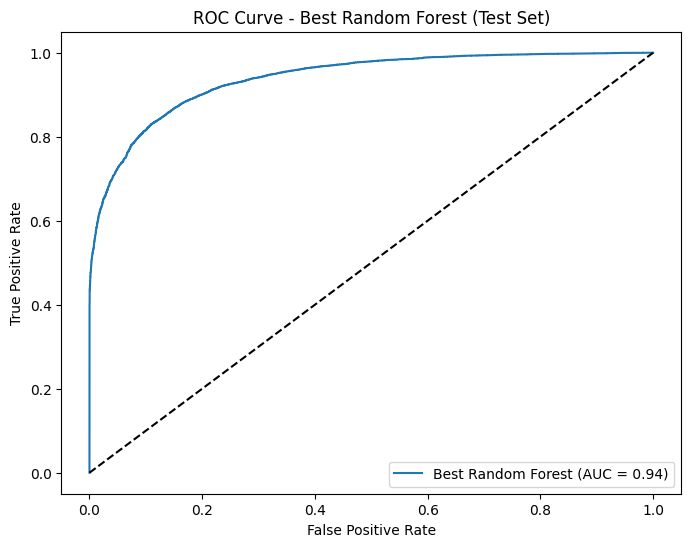

In [ ]:
# We evaluate the best Random Forest model on the test set to estimate its final performance.

print("\n--- Evaluate the Best Random Forest Model on the Test Set ---")

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Make Predictions on the Test Set
# We use the best Random Forest model to make predictions on the test set.
y_pred = best_rf_model.predict(X_test)

# 2. Calculate Evaluation Metrics
# We calculate various evaluation metrics to assess the model's performance.

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Random Forest Accuracy on Test Set: {accuracy:.4f}")

# Print classification report
report = classification_report(y_test, y_pred)
print(f"Best Random Forest Classification Report on Test Set:\n{report}")

# Print confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(f"Best Random Forest Confusion Matrix on Test Set:\n{matrix}")

# Calculate ROC AUC score
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Best Random Forest ROC AUC on Test Set: {roc_auc:.4f}")

# 3. Plot ROC Curve
# We plot the ROC curve to visualize the model's performance.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Best Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Random Forest (Test Set)')
plt.legend()
plt.show()


Okay, the best Random Forest model has been successfully evaluated on the test set. Here are the results:

Accuracy on Test Set: 0.8704
ROC AUC on Test Set: 0.9387
Comparison with Validation Set Results:

Accuracy (Validation): 0.8762
ROC AUC (Validation): 0.9410
Accuracy (Test): 0.8704
ROC AUC (Test): 0.9387
The test set results are very close to the validation set results, which indicates that the model is generalizing well to unseen data and is not overfitting. The model is performing consistently on both the validation and test sets.

Given these results, it seems like we have reached a good level of performance with the Random Forest model. Further optimization may yield only marginal improvements, and it may not be worth the effort given the time and resources required.

#25. Saving the Best Random Forest Model

In [ ]:
# We save the trained model so we can reuse it later without retraining.

print("\n--- Saving the Best Random Forest Model ---")

import pickle

# Define the file path where we want to save the model
MODEL_FILE_PATH = '/content/drive/MyDrive/FinalProject/best_random_forest_model.pkl'  # .pkl is a common extension for pickled objects

# Save the model to the specified file path
with open(MODEL_FILE_PATH, 'wb') as file:  # 'wb' mode for writing in binary format
    pickle.dump(best_rf_model, file)

print(f"Saved Best Random Forest model to: {MODEL_FILE_PATH}")


--- Saving the Best Random Forest Model ---
Saved Best Random Forest model to: /content/drive/MyDrive/FinalProject/best_random_forest_model.pkl
